# Previsão de Vendas da Rossmann com Redes Neurais

### Um modelo de redes neurais será utilizado para fazer previões sobre as vendas diárias da rede Rossman.

Um modelo de regressão linear será utilizado para comparar o desempenho em relação à rede neural.

A Rossmann é uma grande rede de farmácias. É importante o uso de machine learning para otimizar estoque, promoções e alocação de funcionários.

O objetivo é desenvolver um modelo de Machine Learning utilizando Redes Neurais
para prever as vendas diárias das lojas Rossmann com base em dados históricos.


### Importações

In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers


## Preparação de dados

In [14]:
train_path =  '/kaggle/input/rossmann-store-sales/train.csv'
store_path = '/kaggle/input/rossmann-store-sales/store.csv'
test_path = '/kaggle/input/rossmann-store-sales/test.csv'

train = pd.read_csv(train_path)
store = pd.read_csv(store_path)

print("Formato dos dados")
print("Dados de treinamento", train.shape)
print("Dados das lojas", store.shape)

Formato dos dados
Dados de treinamento (1017209, 9)
Dados das lojas (1115, 10)


/tmp/ipykernel_35/2025525622.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(train_path)


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [16]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


Os dados serão unidos e será iniciada a análise exploratória.

In [17]:
df = train.merge(store, on="Store", how="left")
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### Verificando a distribuição dos dados

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


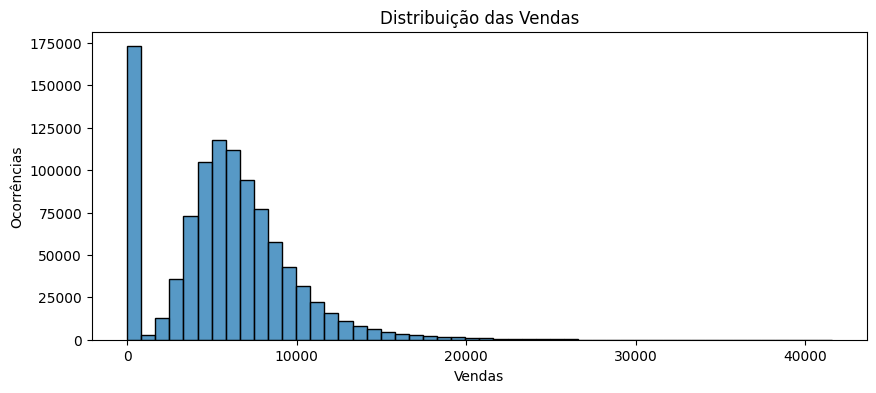

In [18]:
plt.figure(figsize=(10,4))
sns.histplot(df["Sales"], bins=50)
plt.title("Distribuição das Vendas")
plt.ylabel("Ocorrências")
plt.xlabel("Vendas")
plt.show()

As colunas de mês, dia, ano e a coluna booleana IsWeekendo serão criadas a partir da coluna Date.

In [19]:
df["Date"] = pd.to_datetime(df["Date"])

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["IsWeekend"] = df["DayOfWeek"].isin([6,7]).astype(int)


Contando as linhas com dados nulos e preenchendo os dados dulos da coluna CompetitionDistance com o valor da mediana:

In [20]:
df.isnull().sum()
df["CompetitionDistance"].fillna(df["CompetitionDistance"].median(), inplace=True)


/tmp/ipykernel_35/1252033452.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["CompetitionDistance"].fillna(df["CompetitionDistance"].median(), inplace=True)


### Escolhendo as features

As linhas com dados nulos serão excluídas.

In [21]:
num_features = [
    "Customers",
    "CompetitionDistance",
    "Promo",
    "Promo2",
    "Year",
    "Month",
    "Day",
    "IsWeekend"
]

cat_features = [
    "StoreType",
    "Assortment",
    "StateHoliday"
]

target = "Sales"

df = df.dropna(subset=num_features + cat_features + [target])

#É necessário converter a coluna StateHoliday para Strnig
df['StateHoliday'] = df['StateHoliday'].astype(str)

X = df[num_features + cat_features]
y = df[target]


## Pré-processamento

Serão utilizados o StandardScaler para variáveis numéricas e OneHotEncoder para variáveis categóricas. O preprocessor será criado para uso posterior.

In [22]:
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)


Separação dos dados de treinamento e teste.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Modelo de Regressão Linear

In [24]:
from sklearn.linear_model import LinearRegression

linear_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

linear_model.fit(X_train, y_train)

preds_linear_model = linear_model.predict(X_test)


As métricas Mean Absolute Error e Root Mean Square Error serão utilizadas para avaliar o modelo.

In [25]:
mae_linear_model = mean_absolute_error(y_test, preds_linear_model)
rmse_linear_model = np.sqrt(mean_squared_error(y_test, preds_linear_model))

print("Linear Model MAE:", mae_linear_model)
print("Linear Model RMSE:", rmse_linear_model)

Linear Model MAE: 887.4100936377142
Linear Model RMSE: 1251.4456961503363


### A rede neural

A rede neural será criada com 3 camadas, sendo duas com ativação "relu" e a camada output. O otimizador escolhido foi o Adam. O preprocessor criado anteriormente será utilizado para tratar as variáveis numéricas e categóricas.

In [29]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

model = tf.keras.Sequential([
    layers.Input(shape=(X_train_prep.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    X_train_prep,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/20
20345/20345 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 4907963.5000 - mae: 1251.8511 - val_loss: 1100096.2500 - val_mae: 708.1810
Epoch 2/20
20345/20345 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 1064289.6250 - mae: 699.0447 - val_loss: 1032035.8750 - val_mae: 680.4260
Epoch 3/20
20345/20345 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 1007798.8750 - mae: 680.6149 - val_loss: 1006072.3750 - val_mae: 672.6932
Epoch 4/20
20345/20345 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 999253.5000 - mae: 677.1957 - val_loss: 996162.3750 - val_mae: 679.5306
Epoch 5/20
20345/20345 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 982436.2500 - mae: 674.3657 - val_loss: 978963.5000 - val_mae: 667.6610
Epoch 6/20
20345/20345 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 967378.3125 - mae: 669.8725 - val_loss: 967858.5000 - val_mae: 665.7589
Epoch 7/20
20345/20345 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 952849.0625 - mae: 666.3849 - val_loss: 989289.7500 - val_mae: 680.5758
Epoch 8/20
20345/20345 ━━━━━━━━━━━

In [30]:
preds_nn = model.predict(X_test_prep)

mae_nn = mean_absolute_error(y_test, preds_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, preds_nn))

print("Neural Network MAE:", mae_nn)
print("Neural Network RMSE:", rmse_nn)


6358/6358 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Neural Network MAE: 663.5412669266401
Neural Network RMSE: 956.6467940952238


In [32]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Neural Network"],
    "MAE": [mae_linear_model, mae_nn],
    "RMSE": [rmse_linear_model, rmse_nn]
})

results


,Model,MAE,RMSE
0,Linear Regression,887.410094,1251.445696
1,Neural Network,663.541267,956.646794


## Conclusão

- O modelo de regressão linear obteve com as métricas MAR e RMSE de 887 e 1251, respectivamente, enquanto a rede neural obteve 663 e 956.
- A Rede Neural conseguiu capturar padrões não-lineares presentes nos dados.
- O modelo pode auxiliar a empresa na previsão de vendas futuras.
- A inclusão de dados externos como clima poderiam ajudar a melhorar o modelo, assim como o ajuste de hiperparâmetros.
